# Классификатор сердечно - сосудистых заболеваний по демографическому опроснику

План:

1. Загрузка датасета (пол, возраст, уровень дохода, образование, уровень бедности) https://cdc.gov/
2. Список анализов. Standard Biochemistry Profile и Complete Blood Count with 5-Part Differential
3. Взять метку Medical Conditions MCQ160B
4. Обработка датасета, сохранение датасета в csv
5. train test split
6. Тестовый датасет csv 
7. Классификатор sklearn 
8. Натренировать классификатор, выдать метрики
9. Сохранить модель


### Импорт библиотек

In [ ]:
# Общие библиотеки
import pandas as pd # для работы с датафреймами
import numpy as np # обработка массивов
import matplotlib.pyplot as plt # визуализация 
import seaborn as sns # визуализация

import pickle # сохранение моделей

from functools import reduce 
from google.colab import files # для работы с локальными данными
%matplotlib inline

In [ ]:
#Импорт библиотек, для теста нормального распределения
from scipy.stats import kurtosis # экцесс
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest

In [ ]:
# Box-cox transformation # для нормализации данных
from sklearn.preprocessing import PowerTransformer
yeo = PowerTransformer(method = 'yeo-johnson', standardize = True ) # yeo jhonson

In [ ]:
# Импортируем библиотеки ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.externals import joblib #сохранение модели (альтернатива pickle)
from sklearn import naive_bayes as nb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, precision_score, auc, roc_auc_score,balanced_accuracy_score,confusion_matrix
from sklearn import svm

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Подключаем Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Подготовка данных

In [ ]:
# Выводим список файлов в папке
file_list = drive.ListFile({'q': "'1DNAMHRzBvQb2ItyEoCBPLuYluNAVQkI0' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: CBC_F.XPT, id: 10F3-6HK2sFOeassB3UMyVWCBNPlZzctM
title: CBC_H.XPT, id: 18mnMeDe9o8totoDCETYtO7PCvqxZE4Qd
title: L40_B.XPT, id: 13qdE7S2ccCQ7h57l-ipcBwN7jyi2BGUV
title: CBC_G.XPT, id: 10JiwIBZ-e9FnS-VZ3vD-kzn8awqKI5Un
title: L40_C.XPT, id: 16y22gkc7_UIq47Z1eBUp8RZqQVY0h3po
title: CBC_I.XPT, id: 1O_Psl-8PfIUf7aOAEcRdRg1Mm4g1eCQn
title: BIOPRO_D.XPT, id: 191FvPGk51WQdhMugo6JX7B9B4PSBo6p3
title: DEMO.XPT, id: 1vFm-mtXb-wywwys_O-Fk-dOHAzs5Jwf7
title: DEMO_E.XPT, id: 1ylCBwmJjBxdq2q-MgZOmrzUWcOnD_S6Y
title: BIOPRO_F.XPT, id: 1LbzcgaP333i3LmWsBmwq-Bn-cXyq5xcv
title: DEMO_B.XPT, id: 1mKnHUmX8xUbkMEEKVsxblGT8yx1Ozy-8
title: DEMO_D.XPT, id: 1iCmbkrgW0hPkaj36g6P20lnIdiQ25Dcc
title: BIOPRO_E.XPT, id: 1BfxWUJs3z0giE6Ou_74xuuR268E0eWu1
title: BIOPRO_G.XPT, id: 1LU8ca_fR6AEz3VxxfF2T0dX2sn9j676X
title: BIOPRO_H.XPT, id: 1V5rbf7lOhQUhEmyr8xWVG5Hs3Pu6XiTS
title: BIOPRO_I.XPT, id: 1LEsDSeddMuauVCSCS2mByZlfo4mb8Wx2
title: DEMO_C.XPT, id: 1MfK8WtR3K5PQnYeQHxbatgauiEoEdjlK
title: LAB25.XPT, id: 1V184

In [ ]:
# получаем все файлы в списке
files = list()
def get_dict(lst):
  for file1 in file_list:
    files_dict = dict()
    files_dict['title'] = file1['title']
    files_dict['id'] = file1['id']
    lst.append(files_dict)
    #print(files_dict)
    train_downloaded = drive.CreateFile({'id': file1['id']})
    train_downloaded.GetContentFile(file1['title'])
  return

In [ ]:
get_dict(files)

In [ ]:
!ls  #список файлов в директории content  

adc.json      CBC_D.XPT   DEMO_C.XPT  DEMO.XPT	 MCQ_B.XPT  MCQ_I.XPT
BIOPRO_D.XPT  CBC_E.XPT   DEMO_D.XPT  L25_B.XPT  MCQ_C.XPT  MCQ.XPT
BIOPRO_E.XPT  CBC_F.XPT   DEMO_E.XPT  L25_C.XPT  MCQ_D.XPT  sample_data
BIOPRO_F.XPT  CBC_G.XPT   DEMO_F.XPT  L40_B.XPT  MCQ_E.XPT
BIOPRO_G.XPT  CBC_H.XPT   DEMO_G.XPT  L40_C.XPT  MCQ_F.XPT
BIOPRO_H.XPT  CBC_I.XPT   DEMO_H.XPT  LAB18.XPT  MCQ_G.XPT
BIOPRO_I.XPT  DEMO_B.XPT  DEMO_I.XPT  LAB25.XPT  MCQ_H.XPT


**Загрузка демографии**

In [ ]:
# создаем dataframes демография
data_demo_a = pd.read_sas('DEMO.XPT')
data_demo_b = pd.read_sas('DEMO_B.XPT')
data_demo_c = pd.read_sas('DEMO_C.XPT')
data_demo_d = pd.read_sas('DEMO_D.XPT')
data_demo_e = pd.read_sas('DEMO_E.XPT')
data_demo_f = pd.read_sas('DEMO_F.XPT')
data_demo_g = pd.read_sas('DEMO_G.XPT')
data_demo_h = pd.read_sas('DEMO_H.XPT')
data_demo_i = pd.read_sas('DEMO_I.XPT')

In [ ]:
# Объединяем датафрейм с демографией
data_demo = pd.concat([data_demo_a,
                       data_demo_b, 
                       data_demo_c,
                       data_demo_d,
                       data_demo_e,
                       data_demo_f,
                       data_demo_g,
                       data_demo_h,
                       data_demo_i], axis = 0, ignore_index = True )

**Загрузка анализов: Complete Blood Count with 5-part Differential - Whole Blood**

In [ ]:
# Создаем dataframes Complete Blood Count with 5-Part Differential
dab_a = pd.read_sas('LAB25.XPT')
dab_b = pd.read_sas('L25_B.XPT') 
dab_c = pd.read_sas('L25_C.XPT') 
dab_d = pd.read_sas('CBC_D.XPT') 
dab_e = pd.read_sas('CBC_E.XPT') 
dab_f = pd.read_sas('CBC_F.XPT') 
dab_g = pd.read_sas('CBC_G.XPT') 
dab_h = pd.read_sas('CBC_H.XPT') 
dab_i = pd.read_sas('CBC_I.XPT')

In [ ]:
# объединяем Complete Blood Count with 5-Part Differential
dab_full = pd.concat([dab_a,
                      dab_b, 
                      dab_c,
                      dab_d,
                      dab_e,
                      dab_f,
                      dab_g,
                      dab_h,
                      dab_i], axis = 0, ignore_index = True )

**Загрузка анализов: Standard Biochemistry Profile**

In [ ]:
# Создание dataframes Standard Biochemistry Profile
db_a = pd.read_sas('LAB18.XPT')
db_b = pd.read_sas('L40_B.XPT')
db_c = pd.read_sas('L40_C.XPT')
db_d = pd.read_sas('BIOPRO_D.XPT')
db_e = pd.read_sas('BIOPRO_E.XPT')
db_f = pd.read_sas('BIOPRO_F.XPT')
db_g = pd.read_sas('BIOPRO_G.XPT')
db_h = pd.read_sas('BIOPRO_H.XPT')
db_i = pd.read_sas('BIOPRO_I.XPT')

In [ ]:
# Объединяем Standard Biochemistry Profile
db_full = pd.concat([db_a,
                      db_b, 
                      db_c,
                      db_d,
                      db_e,
                      db_f,
                      db_g,
                      db_h,
                      db_i], axis = 0, ignore_index = True )

**Загрузка Y. “Medical Conditions” MCQ160b, MCQ160c,
MCQ160d, MCQ160e, MCQ160f**

In [ ]:
# dataframes “Medical Conditions” MCQ160b, MCQ160c, MCQ160d, MCQ160e, MCQ160f
y_a = pd.read_sas('MCQ.XPT')
y_b = pd.read_sas('MCQ_B.XPT')
y_c = pd.read_sas('MCQ_C.XPT')
y_d = pd.read_sas('MCQ_D.XPT')
y_e = pd.read_sas('MCQ_E.XPT')
y_f = pd.read_sas('MCQ_F.XPT')
y_g = pd.read_sas('MCQ_G.XPT')
y_h = pd.read_sas('MCQ_H.XPT')
y_i = pd.read_sas('MCQ_I.XPT')


In [ ]:
# Объединяем “Medical Conditions” MCQ160b, MCQ160c, MCQ160d, MCQ160e, MCQ160f
y_full = pd.concat([y_a,
                      y_b, 
                      y_c,
                      y_d,
                      y_e,
                      y_f,
                      y_g,
                      y_h,
                      y_i], axis = 0, ignore_index = True )

## Data  preparation and features engineering

### Y full

In [ ]:
# вытаскиваем нужные столбцы
y_full = y_full[['SEQN', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F']]

In [ ]:
y_full.head()

,SEQN,MCQ160B,MCQ160C,MCQ160D,MCQ160E,MCQ160F
0,1.0,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,2.0,2.0,2.0,2.0
2,3.0,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN
4,5.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
# считаем пропуски
percent_missing = y_full.isna().sum() * 100 / len(y_full)
missing_y = pd.DataFrame({'column_name': y_full.columns,
                                 'percent_missing': percent_missing})
# mask = missing_y['percent_missing'] < 50
missing_y

,column_name,percent_missing
SEQN,SEQN,0.000000
MCQ160B,MCQ160B,43.684737
MCQ160C,MCQ160C,43.684737
MCQ160D,MCQ160D,43.684737
MCQ160E,MCQ160E,43.684737
MCQ160F,MCQ160F,43.684737


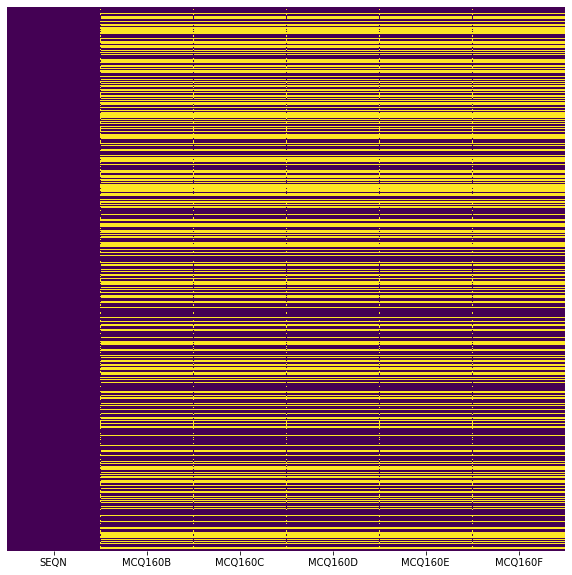

In [ ]:
# Смотрим целостность датафрейма y_full на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(y_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

Целевые столбцы визуально идентичны, имеют одинакове процент пропущенных значений, и одинаковую структуру пропусков. Ввиду этого, можно оставить целевой "y" 1 столбец

In [ ]:
# Y таргет
y_full = y_full[['SEQN', 'MCQ160B']]

In [ ]:
# Посмотрим размерность датафремйма
y_full.shape

(87914, 2)

In [ ]:
# Сморим статистику значений 

y_full['MCQ160B'].value_counts()

2.0    47641
1.0     1705
9.0      160
7.0        3
Name: MCQ160B, dtype: int64

In [ ]:
# смотрим пропуски

y_full.isna().sum()

SEQN           0
MCQ160B    38405
dtype: int64

**Работа с пропусками** Т.к. количество пропуском примерно 43%. Присвоим ему значение = 0, так мы сможем выделить результат в отдельный класс для дополнительных анализов

In [ ]:
# Работа с пропусками, присвоим пропускам значение = 0
y_full['MCQ160B'] = y_full['MCQ160B'].fillna(value = 0) ### 9999999
y_full.head(15)

,SEQN,MCQ160B
0,1.0,0.0
1,2.0,2.0
2,3.0,0.0
3,4.0,0.0
4,5.0,2.0
5,6.0,0.0
6,7.0,2.0
7,8.0,0.0
8,9.0,0.0
9,10.0,2.0


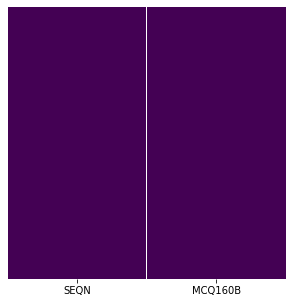

In [ ]:
# проверим Y датасет визуально  на пропуски

fig, ax = plt.subplots(figsize = (5,5))
sns_heatmap = sns.heatmap(y_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

Dataset y_full готов

###Demographic

**Выбираем features demographic**

In [ ]:
# Выбираем столбцы согласно ТЗ и описанию на странице
# Ссылка на страницу с полями: https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/DEMO.htm

data_demo_feat = data_demo[['SEQN','RIAGENDR', 'RIDAGEMN', 'INDFMINC',  'INDHHINC', 'DMDMARTL', 'RIDRETH1', 'INDFMPIR']]

In [ ]:
data_demo_feat.head(10)

,SEQN,RIAGENDR,RIDAGEMN,INDFMINC,INDHHINC,DMDMARTL,RIDRETH1,INDFMPIR
0,1.0,2.0,29.0,3.0,3.0,NaN,4.0,0.86
1,2.0,1.0,926.0,8.0,8.0,NaN,3.0,5.00
2,3.0,2.0,125.0,6.0,6.0,NaN,3.0,1.47
3,4.0,1.0,22.0,3.0,3.0,NaN,4.0,0.57
4,5.0,1.0,597.0,11.0,11.0,1.0,3.0,5.00
5,6.0,2.0,230.0,3.0,4.0,5.0,5.0,1.21
6,7.0,2.0,712.0,NaN,NaN,1.0,4.0,NaN
7,8.0,1.0,159.0,3.0,4.0,NaN,3.0,0.53
8,9.0,2.0,133.0,99.0,NaN,NaN,4.0,NaN
9,10.0,1.0,518.0,99.0,NaN,4.0,4.0,NaN


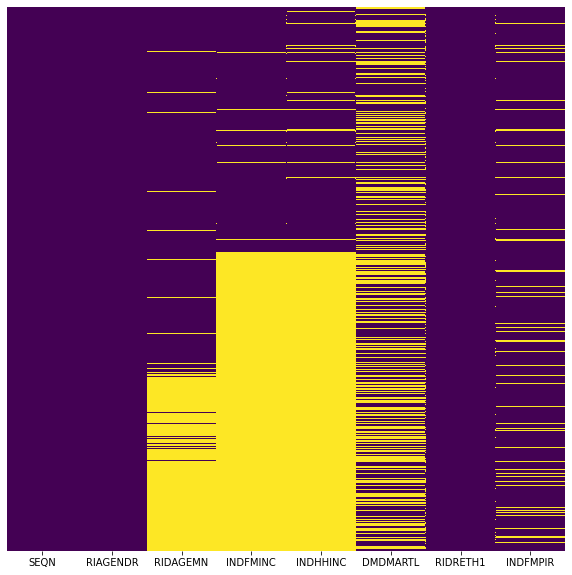

In [ ]:
#смотрим датасет Demographic на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(data_demo_feat.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Посмотрим данные
data_demo_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92062 entries, 0 to 92061
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      92062 non-null  float64
 1   RIAGENDR  92062 non-null  float64
 2   RIDAGEMN  62488 non-null  float64
 3   INDFMINC  40831 non-null  float64
 4   INDHHINC  38169 non-null  float64
 5   DMDMARTL  55994 non-null  float64
 6   RIDRETH1  92062 non-null  float64
 7   INDFMPIR  84097 non-null  float64
dtypes: float64(8)
memory usage: 5.6 MB


In [ ]:
# Посмотрим какие значения в столбцах с пропусками
print('INDFMINC')
print(data_demo_feat['INDFMINC'].value_counts())
print('INDHHINC')
print(data_demo_feat['INDHHINC'].value_counts())
print('DMDMARTL')
print(data_demo_feat['DMDMARTL'].value_counts())

INDFMINC
11.0    6393
6.0     4824
3.0     4167
7.0     3627
5.0     3577
4.0     3574
8.0     3092
2.0     2896
1.0     2107
9.0     2105
10.0    1714
12.0     899
13.0     739
99.0     561
77.0     556
Name: INDFMINC, dtype: int64
INDHHINC
11.0    7338
6.0     5046
7.0     3882
3.0     3459
4.0     3286
5.0     3267
8.0     3262
9.0     2387
2.0     2223
10.0    1837
1.0     1069
12.0     537
99.0     262
13.0     177
77.0     137
Name: INDHHINC, dtype: int64
DMDMARTL
1.0     25841
5.0     15266
3.0      4958
2.0      4584
6.0      3671
4.0      1631
77.0       36
99.0        7
Name: DMDMARTL, dtype: int64


In [ ]:
# посмотрим количество пропусков
data_demo_feat.isna().sum()

SEQN            0
RIAGENDR        0
RIDAGEMN    29574
INDFMINC    51231
INDHHINC    53893
DMDMARTL    36068
RIDRETH1        0
INDFMPIR     7965
dtype: int64

**Заполним попуски средним значением**

In [ ]:
#Заполняем пропуски
data_demo_feat = data_demo_feat.fillna(data_demo_feat.mean())

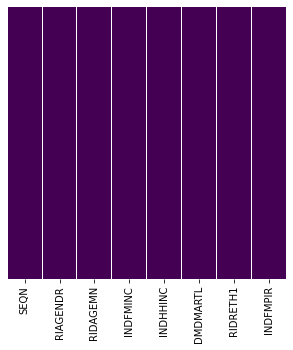

In [ ]:
# смотрим датасет Demographic на NaN

fig, ax = plt.subplots(figsize = (5,5))
sns_heatmap = sns.heatmap(data_demo_feat.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

Проведем тест на нормальное распределение значений в столбцах

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61e02b6e10>,
      dtype=object)

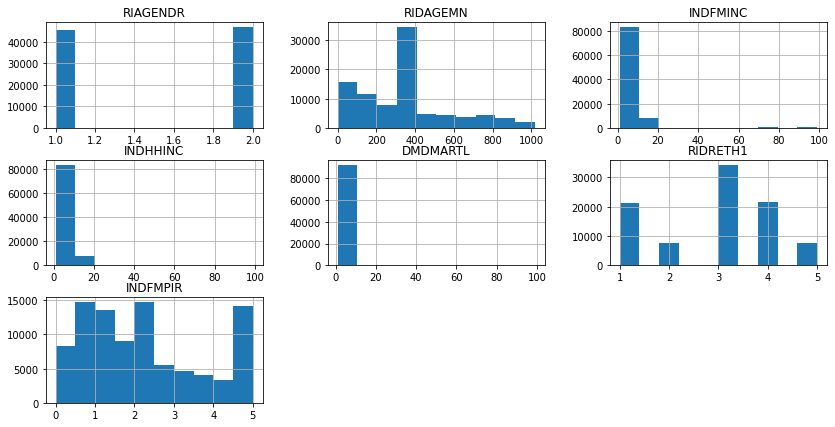

In [ ]:
# Визуализируем распределение
data_demo_feat[['RIAGENDR','RIDAGEMN', 'INDFMINC', 'INDHHINC','DMDMARTL','RIDRETH1', 'INDFMPIR']].hist(figsize=(14,7))

Нормализуем данные

In [ ]:
# Функция которая проводит тест данных на нормальность
def analyze(data):
    plt.style.use('ggplot')
    np.var(data)
    plt.hist(data, bins=60)
    print("mean : ", np.mean(data))
    print("var  : ", np.var(data))
    print("skew : ", skew(data))
    print("kurt : ", kurtosis(data))
    print("shapiro : ", shapiro(data))
    print("normaltest : ", normaltest(data))

mean :  342.4396044044347
var  :  55923.89500626578
skew :  0.7913003049306148
kurt :  0.22230224738678128
shapiro :  (0.9143497943878174, 0.0)
normaltest :  NormaltestResult(statistic=7710.601971988043, pvalue=0.0)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


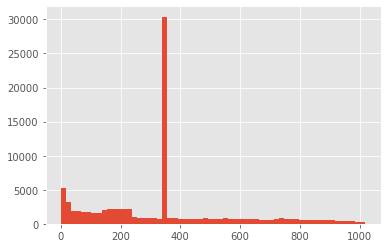

In [ ]:
print(analyze(data_demo_feat['RIDAGEMN'])) 

mean :  5.166348474067196e-15
var  :  0.9999999999990682
skew :  -0.14986134650603836
kurt :  -0.2749306247037766
shapiro :  (0.9551900029182434, 0.0)
normaltest :  NormaltestResult(statistic=733.3556633533237, pvalue=5.673369460714954e-160)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


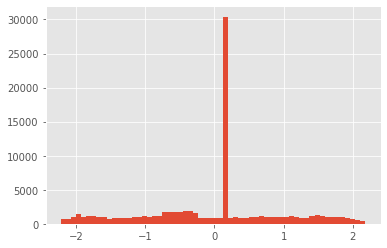

In [ ]:
#Нормализуем
data_demo_feat['RIDAGEMN'] = yeo.fit_transform(data_demo_feat['RIDAGEMN'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['RIDAGEMN'])

mean :  8.738556488961793
var  :  84.65833992874664
skew :  8.174785910179816
kurt :  71.76387151384614
shapiro :  (0.25613933801651, 0.0)
normaltest :  NormaltestResult(statistic=125399.79678370079, pvalue=0.0)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


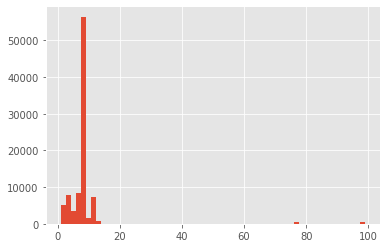

In [ ]:
print(analyze(data_demo_feat['INDFMINC'])) 

mean :  9.331133767079656e-16
var  :  1.0000000000018678
skew :  0.037030570699884094
kurt :  -0.2632834496907215
shapiro :  (0.9572623372077942, 0.0)
normaltest :  NormaltestResult(statistic=375.8778429441927, pvalue=2.3942167776074304e-82)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


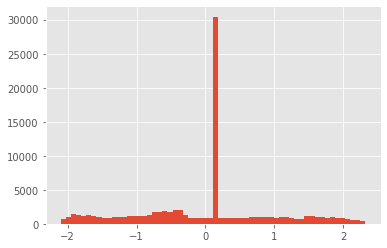

In [ ]:
#Нормализуем
data_demo_feat['INDFMINC'] = yeo.fit_transform(data_demo_feat['RIDAGEMN'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['INDFMINC'])

mean :  7.721449343715056
var  :  35.113732586976276
skew :  12.726992193143055
kurt :  185.1052413532019
shapiro :  (0.2343614101409912, 0.0)
normaltest :  NormaltestResult(statistic=161169.8895502802, pvalue=0.0)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


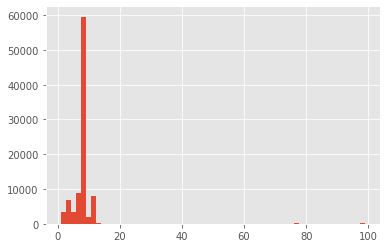

In [ ]:
print(analyze(data_demo_feat['INDHHINC'])) 


mean :  -1.518507596198873e-14
var  :  0.9999999999972182
skew :  0.026837100790780194
kurt :  12.901968797379421
shapiro :  (0.6785331964492798, 0.0)
normaltest :  NormaltestResult(statistic=18313.253917712158, pvalue=0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


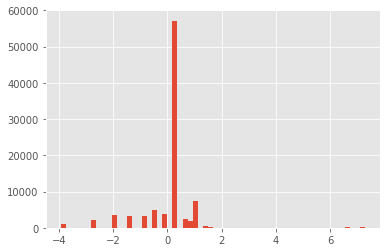

In [ ]:
#Нормализуем
data_demo_feat['INDHHINC'] = yeo.fit_transform(data_demo_feat['INDHHINC'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['INDHHINC'])

mean :  -1.660674740531887e-14
var  :  0.999999999999101
skew :  -0.0009175987672220979
kurt :  0.04810726066438464
shapiro :  (0.8442375063896179, 0.0)
normaltest :  NormaltestResult(statistic=8.552490338996547, pvalue=0.013894736640686987)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


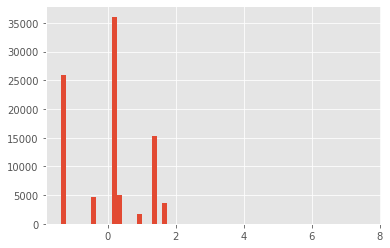

In [ ]:
print(analyze(data_demo_feat['DMDMARTL'])) 


mean :  -1.660674740531887e-14
var  :  0.999999999999101
skew :  -0.0009175987672220979
kurt :  0.04810726066438464
shapiro :  (0.8442375063896179, 0.0)
normaltest :  NormaltestResult(statistic=8.552490338996547, pvalue=0.013894736640686987)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


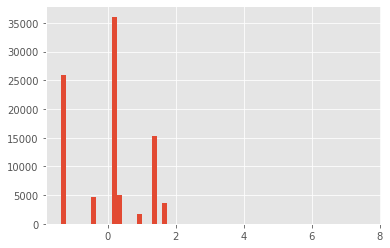

In [ ]:
#Нормализуем
data_demo_feat['DMDMARTL'] = yeo.fit_transform(data_demo_feat['DMDMARTL'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['DMDMARTL'])

mean :  2.861843105733093
var  :  1.5462816630319707
skew :  -0.1909245338998197
kurt :  -0.9355647211917009
shapiro :  (0.8796019554138184, 0.0)
normaltest :  NormaltestResult(statistic=15673.84859059018, pvalue=0.0)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


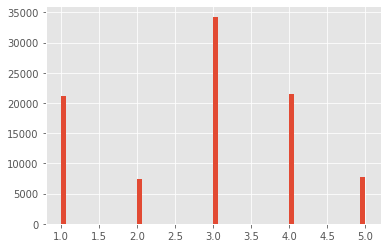

In [ ]:
print(analyze(data_demo_feat['RIDRETH1'])) 


mean :  2.7137340685039837e-14
var  :  0.9999999999997944
skew :  -0.1462729848872042
kurt :  -0.9224920323801711
shapiro :  (0.8817532062530518, 0.0)
normaltest :  NormaltestResult(statistic=14488.036167987088, pvalue=0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


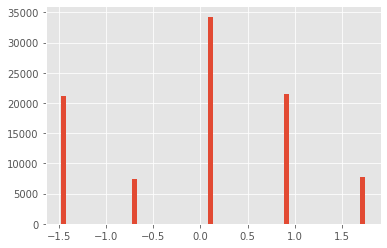

In [ ]:
#Нормализуем
data_demo_feat['RIDRETH1'] = yeo.fit_transform(data_demo_feat['RIDRETH1'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['RIDRETH1'])

mean :  2.262297109290639
var  :  2.34176329478367
skew :  0.5596867094247817
kurt :  -0.8900050620753537
shapiro :  (0.9098568558692932, 0.0)
normaltest :  NormaltestResult(statistic=16262.213170446033, pvalue=0.0)
None


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


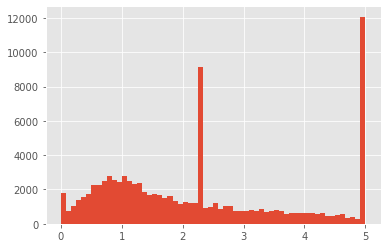

In [ ]:
print(analyze(data_demo_feat['INDFMPIR'])) 


mean :  -1.9787974975412595e-16
var  :  0.9999999999997852
skew :  -0.018308481633149434
kurt :  -0.967401815841078
shapiro :  (0.9586137533187866, 0.0)
normaltest :  NormaltestResult(statistic=17808.117202560195, pvalue=0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


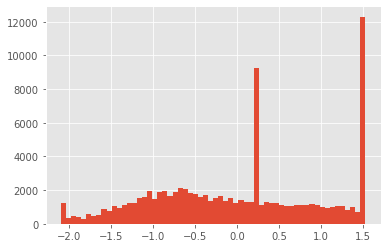

In [ ]:
#Нормализуем
data_demo_feat['INDFMPIR'] = yeo.fit_transform(data_demo_feat['INDFMPIR'].values.reshape(data_demo_feat.shape[0], -1))
analyze(data_demo_feat['INDFMPIR'])

Dataset готов

### Анализы Complete Blood Count with 5-Part Differential

In [ ]:
# Посмотрим размерность
dab_full.shape

(84065, 22)

In [ ]:
dab_full.head()

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXMCH
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,7.6,21.1,7.1,66.8,4.4,0.5,1.6,0.5,5.1,0.3,5.397605e-79,4.73,14.1,41.8,88.5,29.7,33.6,13.7,214.0,7.7,NaN
2,3.0,7.5,37.8,8.1,39.0,14.9,0.3,2.8,0.6,2.9,1.1,5.397605e-79,4.52,13.7,39.3,86.9,30.3,34.8,11.7,270.0,8.6,NaN
3,4.0,8.8,57.7,6.2,24.1,11.4,0.6,5.1,0.5,2.1,1.0,1.000000e-01,4.77,9.3,29.4,61.5,19.4,31.6,15.3,471.0,7.8,NaN
4,5.0,5.9,37.8,6.2,52.2,3.4,0.4,2.2,0.4,3.1,0.2,5.397605e-79,5.13,14.5,43.6,84.9,28.3,33.3,13.1,209.0,10.4,NaN


In [ ]:
dab_full.describe()

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXMCH
count,84065.000000,75395.000000,75221.000000,75221.000000,75221.000000,7.522100e+04,7.522100e+04,75218.000000,7.521800e+04,75218.000000,7.521800e+04,7.521800e+04,75398.000000,75398.000000,75398.000000,75398.000000,75398.000000,67281.000000,75398.000000,75396.000000,75396.000000,0.0
mean,46717.110581,7.299697,33.567771,8.023507,54.717072,3.042039e+00,6.964531e-01,2.399367,5.686711e-01,4.066200,2.178588e-01,4.190353e-02,4.669830,13.814889,40.713872,87.377812,29.653890,34.000383,12.970128,271.852178,8.047882,NaN
std,26986.478038,2.381935,10.719347,2.372409,11.774456,2.448866e+00,5.513240e-01,1.263189,2.082394e-01,1.793694,1.962550e-01,6.569604e-02,0.479862,1.505846,4.341077,6.240662,2.423651,0.948556,1.240366,74.882974,0.933535,NaN
min,1.000000,1.400000,2.600000,0.600000,0.800000,5.397605e-79,5.397605e-79,0.200000,5.397605e-79,0.100000,5.397605e-79,5.397605e-79,1.670000,5.800000,16.300000,50.500000,13.800000,25.100000,6.300000,4.000000,4.700000,NaN
25%,23495.000000,5.700000,26.200000,6.400000,47.600000,1.500000e+00,4.000000e-01,1.800000,4.000000e-01,2.800000,1.000000e-01,5.397605e-79,4.350000,12.800000,37.600000,83.800000,28.300000,33.400000,12.200000,221.000000,7.400000,NaN
50%,46536.000000,7.000000,32.400000,7.800000,55.800000,2.400000e+00,6.000000e-01,2.200000,5.000000e-01,3.800000,2.000000e-01,5.397605e-79,4.650000,13.700000,40.400000,87.900000,29.900000,34.000000,12.700000,263.000000,8.000000,NaN
75%,69257.000000,8.500000,39.800000,9.300000,62.800000,3.800000e+00,9.000000e-01,2.800000,7.000000e-01,5.000000,3.000000e-01,1.000000e-01,4.980000,14.900000,43.800000,91.500000,31.200000,34.600000,13.400000,313.000000,8.600000,NaN
max,93702.000000,117.200000,94.500000,66.900000,96.600000,5.720000e+01,3.540000e+01,110.800000,1.020000e+01,83.100000,8.400000e+00,4.700000e+00,9.160000,19.700000,59.900000,125.300000,74.500000,69.600000,37.800000,1000.000000,15.100000,NaN


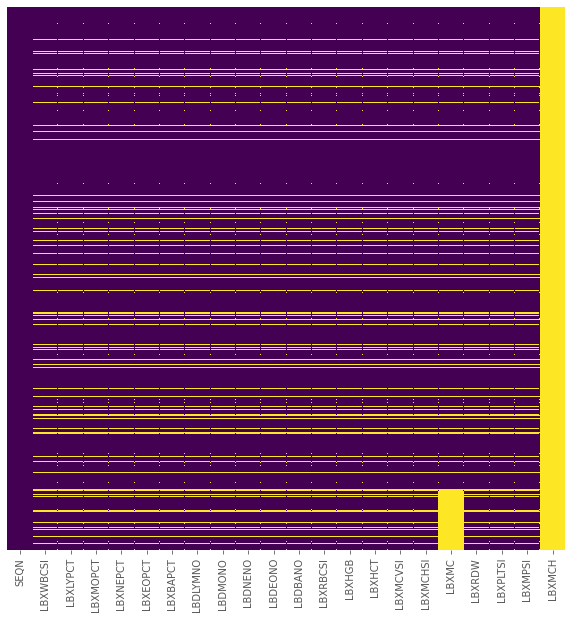

In [ ]:
# Смотрим целостность датафрейма на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(dab_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Удалим колонку с пропусками 100%
dab_full = dab_full.drop(['LBXMCH'], axis=1)

In [ ]:
# заполним пропуски mean
dab_full = dab_full.fillna(dab_full.mean())

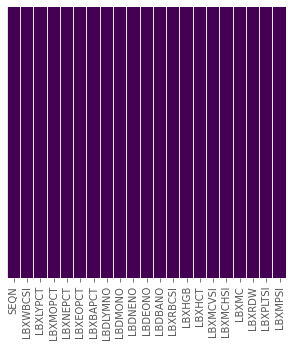

In [ ]:
# Смотрим целостность датафрейма Complete Blood Count with 5-Part Differential  на NaN

fig, ax = plt.subplots(figsize = (5,5))
sns_heatmap = sns.heatmap(dab_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

Ввиду ограничения по времени, пропуски заполнены по средней, однако при наличии времени можно использовать более интеллектуальный способ заполнения NaN.

### Анализы: Standard Biochemistry Profile

In [ ]:
# Посмотрим размерность
db_full.shape

(62731, 47)

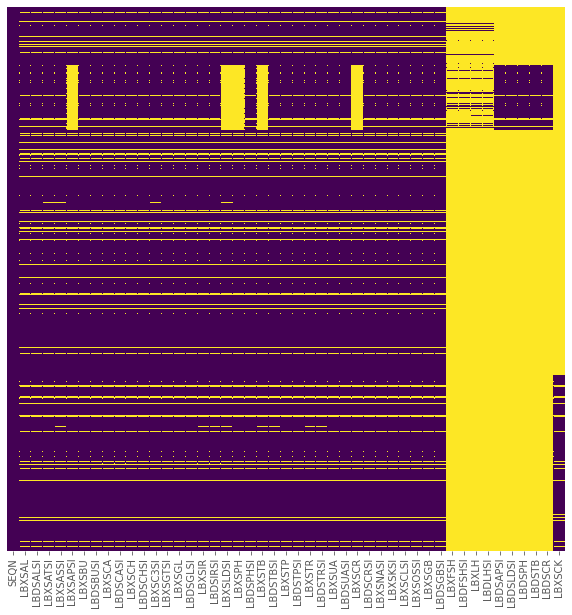

In [ ]:
# Смотрим целостность датафрейма Standard Biochemistry Profile на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(db_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# считаем пропуски
percent_missing = db_full.isna().sum() * 100 / len(db_full)
missing_y = pd.DataFrame({'column_name': db_full.columns,
                                 'percent_missing': percent_missing})
#mask = missing_y['percent_missing'] < 50
missing_y

,column_name,percent_missing
SEQN,SEQN,0.000000
LBXSAL,LBXSAL,7.431732
LBDSALSI,LBDSALSI,7.431732
LBXSATSI,LBXSATSI,7.591143
LBXSASSI,LBXSASSI,7.599114
LBXSAPSI,LBXSAPSI,18.427891
LBXSBU,LBXSBU,7.438109
LBDSBUSI,LBDSBUSI,7.438109
LBXSCA,LBXSCA,7.503467
LBDSCASI,LBDSCASI,7.503467


In [ ]:
# удаляем столбцы с большим количеством пропусков
db_full = db_full.drop(['LBXSCK', 'LBXLH', 'LBXFSH', 'LBDSTB', 'LBDSPH', 
                        'LBDSLDSI', 'LBDSCR', 'LBDSAPSI', 'LBDLHSI', 'LBDFSHSI'],axis =1)


In [ ]:
# заполним пропуски mean
db_full = db_full.fillna(db_full.mean())

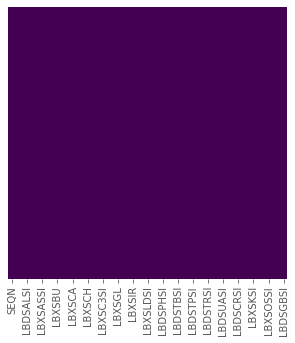

In [ ]:
# Смотрим целостность датафрейма Standard Biochemistry Profile на NaN

fig, ax = plt.subplots(figsize = (5,5))
sns_heatmap = sns.heatmap(db_full.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
db_full.describe()

,SEQN,LBXSAL,LBDSALSI,LBXSATSI,LBXSASSI,LBXSAPSI,LBXSBU,LBDSBUSI,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSC3SI,LBXSGTSI,LBXSGL,LBDSGLSI,LBXSIR,LBDSIRSI,LBXSLDSI,LBXSPH,LBDSPHSI,LBXSTB,LBDSTBSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI,LBXSCR,LBDSCRSI,LBXSNASI,LBXSKSI,LBXSCLSI,LBXSOSSI,LBXSGB,LBDSGBSI
count,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,6.273100e+04,6.273100e+04,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000,62731.000000
mean,46430.254738,4.292989,42.929894,24.098949,25.269253,87.414727,12.805391,4.572136,9.474991,2.368748,187.981089,4.861209,24.582208,26.440795,98.106992,5.445862,84.780471,15.184513,133.626978,3.862182,1.250153,6.850919e-01,1.181850e+01,7.245250,72.452495,137.980962,1.557811,5.315611,316.172530,0.849547,75.144094,139.115918,3.999445,103.580609,277.713014,2.952956,29.529565
std,27017.357140,0.352833,3.528327,22.029557,16.697374,54.672532,5.514647,1.968741,0.366724,0.091681,41.502873,1.073289,2.222149,38.796306,33.910190,1.882370,34.843049,6.240323,30.251945,0.582964,0.201046,2.932205e-01,5.275726e+00,0.477244,4.772441,119.133478,1.345016,1.372476,81.634826,0.383553,36.005116,2.216414,0.326494,2.734530,4.961521,0.434551,4.345514
min,2.000000,1.200000,12.000000,3.000000,7.000000,7.000000,1.000000,0.360000,6.500000,1.625000,6.000000,0.155000,10.000000,3.000000,19.000000,1.050000,2.000000,0.400000,4.000000,1.000000,0.323000,5.397605e-79,5.397605e-79,3.400000,34.000000,9.000000,0.102000,0.400000,23.800000,0.140000,8.840000,99.000000,2.300000,70.000000,201.000000,0.600000,6.000000
25%,23175.500000,4.100000,41.000000,16.000000,20.000000,60.000000,10.000000,3.570000,9.300000,2.325000,159.000000,4.112000,23.000000,13.000000,84.000000,4.660000,62.000000,11.100000,117.000000,3.500000,1.130000,5.000000e-01,8.550000e+00,7.000000,70.000000,73.000000,0.824000,4.400000,261.700000,0.700000,61.880000,138.000000,3.800000,102.000000,275.000000,2.700000,27.000000
50%,46140.000000,4.300000,43.000000,20.000000,23.000000,79.000000,12.000000,4.280000,9.474991,2.368748,187.981089,4.861209,24.582208,19.000000,91.000000,5.051000,84.000000,15.000000,133.626978,3.862182,1.250153,6.850919e-01,1.181850e+01,7.245250,72.452495,114.000000,1.287000,5.300000,315.200000,0.849547,71.600000,139.000000,3.999445,103.580609,277.713014,2.952956,29.529565
75%,69035.500000,4.500000,45.000000,26.000000,27.000000,87.414727,15.000000,5.360000,9.700000,2.425000,211.000000,5.456000,26.000000,26.440795,98.106992,5.445862,103.000000,18.400000,143.000000,4.100000,1.356000,8.000000e-01,1.368000e+01,7.500000,75.000000,160.000000,1.806000,6.100000,362.800000,0.910000,83.100000,140.000000,4.200000,105.000000,280.000000,3.200000,32.000000
max,93702.000000,5.700000,57.000000,1997.000000,1672.000000,1378.000000,122.000000,43.550000,14.800000,3.700000,712.000000,18.412000,43.000000,2274.000000,777.000000,43.130000,557.000000,99.800000,1539.000000,10.900000,3.520000,1.310000e+01,2.240100e+02,11.300000,113.000000,6057.000000,68.384000,18.000000,1070.600000,17.800000,1573.520000,161.000000,7.300000,120.000000,323.000000,7.900000,79.000000


Dataset готов

### Создаем общий dataset

**Последовательно объединяем обработанные ранее данные в DATASET по индексу SEQN**

In [ ]:
# создадим список данных DATASET
dataset_temp = [data_demo_feat, dab_full, db_full, y_full]


# Объеденим по OUTER index = SEQN

dataset = reduce(lambda  left,right: pd.merge(left,right,on=['SEQN'], how='outer'), dataset_temp)

dataset = dataset.set_index(['SEQN'])
dataset.head(10)

,RIAGENDR,RIDAGEMN,INDFMINC,INDHHINC,DMDMARTL,RIDRETH1,INDFMPIR,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXSAL,LBDSALSI,LBXSATSI,LBXSASSI,LBXSAPSI,LBXSBU,LBDSBUSI,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSC3SI,LBXSGTSI,LBXSGL,LBDSGLSI,LBXSIR,LBDSIRSI,LBXSLDSI,LBXSPH,LBDSPHSI,LBXSTB,LBDSTBSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI,LBXSCR,LBDSCRSI,LBXSNASI,LBXSKSI,LBXSCLSI,LBXSOSSI,LBXSGB,LBDSGBSI,MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,2.0,-1.651695,-1.593689,-1.994973,0.221957,0.916553,-0.928971,7.299697,33.567771,8.023507,54.717072,3.042039,6.964531e-01,2.399367,0.568671,4.0662,2.178588e-01,4.190353e-02,4.66983,13.814889,40.713872,87.377812,29.65389,34.000383,12.970128,271.852178,8.047882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2.0,1.0,1.952942,2.062087,0.292809,0.221957,0.097000,1.528525,7.600000,21.100000,7.100000,66.800000,4.400000,5.000000e-01,1.600000,0.500000,5.1000,3.000000e-01,5.397605e-79,4.73000,14.100000,41.800000,88.500000,29.70000,33.600000,13.700000,214.000000,7.700000,4.5,45.0,16.0,19.0,62.0,19.0,6.8,9.3,2.325,203.0,5.25,28.0,20.0,78.0,4.330,63.0,11.28,140.0,3.3,1.066,0.7,12.0,7.2,72.0,115.0,1.298,6.1,362.8,0.7,61.9,144.1,4.06,104.5,288.0,2.7,27.0,2.0
3.0,2.0,-0.865647,-0.873707,-0.419760,0.221957,0.097000,-0.364566,7.500000,37.800000,8.100000,39.000000,14.900000,3.000000e-01,2.800000,0.600000,2.9000,1.100000e+00,5.397605e-79,4.52000,13.700000,39.300000,86.900000,30.30000,34.800000,11.700000,270.000000,8.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4.0,1.0,-1.741556,-1.674348,-1.994973,0.221957,0.916553,-1.257352,8.800000,57.700000,6.200000,24.100000,11.400000,6.000000e-01,5.100000,0.500000,2.1000,1.000000e+00,1.000000e-01,4.77000,9.300000,29.400000,61.500000,19.40000,31.600000,15.300000,471.000000,7.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5.0,1.0,1.052884,1.064450,1.112452,-1.382532,0.097000,1.528525,5.900000,37.800000,6.200000,52.200000,3.400000,4.000000e-01,2.200000,0.400000,3.1000,2.000000e-01,5.397605e-79,5.13000,14.500000,43.600000,84.900000,28.30000,33.300000,13.100000,209.000000,10.400000,4.5,45.0,28.0,22.0,63.0,16.0,5.7,9.5,2.375,277.0,7.16,25.0,34.0,95.0,5.273,137.0,24.54,133.0,3.2,1.033,0.5,8.6,7.3,73.0,341.0,3.850,6.8,404.5,0.8,70.7,137.5,4.63,98.9,276.0,2.8,28.0,2.0
6.0,2.0,-0.301836,-0.336554,-1.368763,1.305783,1.750651,-0.588141,9.600000,19.400000,3.400000,75.300000,2.000000,5.397605e-79,1.900000,0.300000,7.2000,2.000000e-01,5.397605e-79,4.22000,13.100000,38.700000,91.700000,30.90000,33.700000,12.800000,453.000000,7.700000,5.1,51.0,14.0,20.0,78.0,9.0,3.2,9.4,2.350,148.0,3.83,23.0,16.0,79.0,4.385,40.0,7.16,143.0,4.2,1.356,0.3,5.1,8.6,86.0,49.0,0.553,3.0,178.4,0.5,44.2,139.9,4.16,104.0,277.0,3.5,35.0,0.0
7.0,2.0,1.388716,1.431955,0.203491,-1.382532,0.916553,0.207679,4.900000,46.800000,8.500000,43.300000,0.800000,7.000000e-01,2.300000,0.400000,2.1000,5.397605e-79,5.397605e-79,4.60000,13.400000,40.200000,87.400000,29.10000,33.300000,14.300000,244.000000,8.200000,4.5,45.0,15.0,19.0,75.0,10.0,3.6,9.8,2.450,244.0,6.31,24.0,14.0,81.0,4.496,95.0,17.01,179.0,3.6,1.162,0.4,6.8,8.1,81.0,57.0,0.644,4.3,255.8,0.6,53.0,143.2,4.25,101.5,283.0,3.6,36.0,2.0
8.0,1.0,-0.665123,-0.685059,-1.368763,0.221957,0.097000,-1.306778,5.400000,42.700000,9.100000,44.200000,3.100000,9.000000e-01,2.300000,0.500000,2.4000,2.000000e-01,5.397605e-79,4.73000,15.100000,44.100000,93.300000,32.10000,34.400000,12.200000,228.000000,7.500000,4.4,44.0,11.0,27.0,568.0,18.0,6.4,9.7,2.425,157.0,4.06,22.0,8.0,77.0,4.274,114.0,20.42,193.0,5.4,1.744,0.7,

In [ ]:
mask = dataset['MCQ160B'] == 1.0
temp = dataset[mask]
temp

,RIAGENDR,RIDAGEMN,INDFMINC,INDHHINC,DMDMARTL,RIDRETH1,INDFMPIR,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXSAL,LBDSALSI,LBXSATSI,LBXSASSI,LBXSAPSI,LBXSBU,LBDSBUSI,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSC3SI,LBXSGTSI,LBXSGL,LBDSGLSI,LBXSIR,LBDSIRSI,LBXSLDSI,LBXSPH,LBDSPHSI,LBXSTB,LBDSTBSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI,LBXSCR,LBDSCRSI,LBXSNASI,LBXSKSI,LBXSCLSI,LBXSOSSI,LBXSGB,LBDSGBSI,MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197.0,1.0,1.862601,1.960220,-0.855246,0.330259,-0.704665,-0.389274,7.9,33.8,4.6,58.8,2.5,0.3,2.7,0.4,4.6,0.2,5.397605e-79,5.10,16.0,46.8,91.8,31.4,34.200000,13.5,124.0,9.1,4.6,46.0,16.0,18.0,101.0,14.0,5.00,9.2,2.300,201.0,5.200,22.0,27.0,98.0,5.440,107.0,19.16,118.0,2.9,0.936,0.5,8.60,7.6,76.0,156.0,1.761,3.8,226.0,0.90,79.60,138.6,4.10,103.0,277.0,3.0,30.0,1.0
293.0,2.0,0.180257,0.143573,1.341257,-1.382532,0.097000,0.207679,7.0,23.2,10.5,63.0,2.8,0.5,1.6,0.7,4.4,0.2,5.397605e-79,4.99,15.2,45.2,91.4,30.8,33.700000,12.6,243.0,8.7,4.8,48.0,17.0,29.0,65.0,16.0,5.70,9.8,2.450,310.0,8.020,26.0,13.0,97.0,5.384,74.0,13.25,320.0,3.7,1.195,0.6,10.30,7.6,76.0,90.0,1.016,6.1,362.8,0.70,61.90,142.6,4.32,102.8,285.0,2.8,28.0,1.0
321.0,2.0,1.793735,1.882807,0.592503,-0.373624,0.097000,-0.766709,6.6,25.0,7.1,66.3,1.0,0.7,1.7,0.5,4.4,0.1,5.397605e-79,3.89,12.3,36.9,94.7,31.5,33.200000,12.9,195.0,9.9,3.8,38.0,21.0,30.0,57.0,11.0,3.90,8.5,2.125,198.0,5.120,27.0,15.0,91.0,5.051,75.0,13.43,127.0,3.9,1.259,0.4,6.80,6.3,63.0,104.0,1.174,4.1,243.9,0.50,44.20,137.9,4.11,102.2,274.0,2.5,25.0,1.0
421.0,1.0,1.734284,1.816147,-0.419760,-1.382532,0.916553,-0.552282,7.5,31.1,10.1,55.3,3.2,0.3,2.3,0.8,4.1,0.2,5.397605e-79,5.02,13.7,41.6,82.9,27.3,32.800000,14.4,285.0,7.8,4.1,41.0,28.0,27.0,56.0,10.0,3.60,9.3,2.325,187.0,4.840,26.0,30.0,99.0,5.495,105.0,18.81,159.0,3.7,1.195,0.5,8.60,7.7,77.0,80.0,0.903,6.0,356.9,0.90,79.60,139.6,3.66,101.8,278.0,3.6,36.0,1.0
458.0,2.0,1.937999,2.045213,-0.419760,-0.373624,0.097000,0.294331,8.3,13.8,5.5,69.7,10.4,0.6,1.1,0.5,5.8,0.9,5.397605e-79,3.47,11.2,32.8,94.5,32.4,34.300000,11.8,263.0,8.1,4.1,41.0,9.0,17.0,128.0,38.0,13.60,9.8,2.450,196.0,5.070,20.0,14.0,88.0,4.885,46.0,8.24,164.0,3.1,1.001,0.4,6.80,7.7,77.0,105.0,1.185,10.5,624.5,1.30,114.90,138.3,4.78,103.3,285.0,3.6,36.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93549.0,2.0,0.180257,0.143573,0.203491,1.305783,0.916553,-0.766709,6.2,36.0,5.8,55.0,2.3,1.0,2.2,0.4,3.4,0.1,1.000000e-01,3.95,12.7,39.7,100.5,32.3,34.000383,12.8,209.0,8.3,3.8,38.0,21.0,21.0,59.0,15.0,5.36,9.2,2.300,166.0,4.293,27.0,18.0,197.0,10.940,58.0,10.40,139.0,3.2,1.033,0.6,10.26,6.5,65.0,178.0,2.010,5.3,315.2,1.36,120.22,140.0,4.21,105.0,286.0,2.7,27.0,1.0
93611.0,2.0,0.180257,0.143573,0.203491,-1.382532,0.097000,-0.516982,7.4,25.7,11.1,52.4,9.9,1.0,1.9,0.8,3.9,0.7,1.000000e-01,5.30,14.5,43.2,81.5,27.4,34.000383,16.0,167.0,8.8,4.2,42.0,16.0,20.0,58.0,13.0,4.64,9.4,2.350,170.0,4.396,26.0,18.0,96.0,5.330,46.0,8.20,141.0,3.4,1.098,0.2,3.42,6.6,66.0,152.0,1.716,8.5,505.6,0.93,82.21,139.0,3.44,101.0,278.0,2.4,24.0,1.0
93641.0,2.0,0.180257,0.143573,0.203491,-1.382532,0.097000,1.010869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# смотрим размер
dataset.shape

(92062, 64)

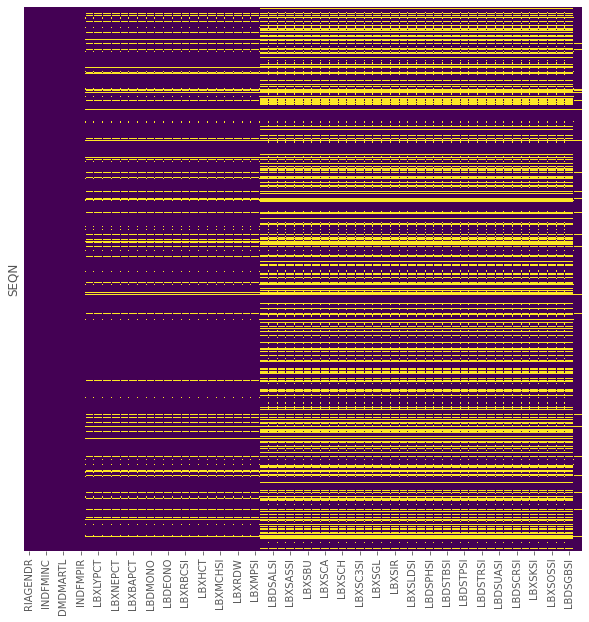

In [ ]:
# Смотрим целостность датафрейма dataset на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(dataset.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Проверим пропуск целевой переменной Y
dataset['MCQ160B'].isna().sum()

4148

ДЛя сохранения корректности показаний анализов и целевой переменной, необходимо удалить строки, которые содержат пустую "Y"

In [ ]:
# Удаляем строки, где Y = NaN
dataset1 = dataset.drop(dataset[(dataset.MCQ160B.isna() == True)].index)

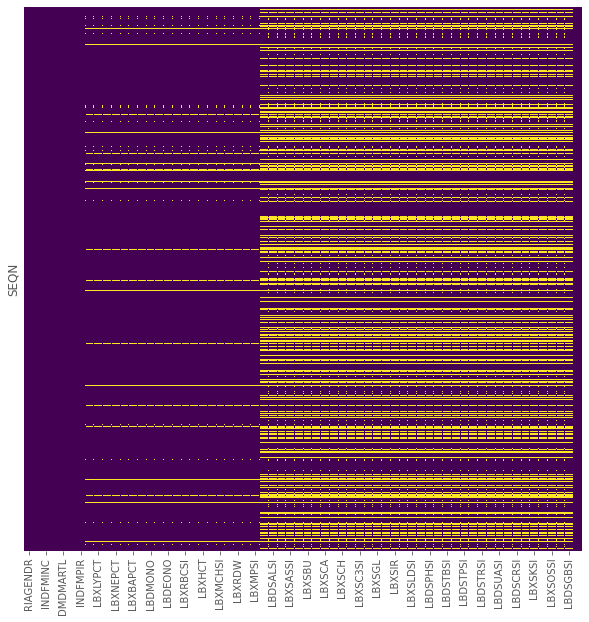

In [ ]:
# Смотрим целостность датафрейма dataset на NaN

fig, ax = plt.subplots(figsize = (10,10))
sns_heatmap = sns.heatmap(dataset1.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Еще раз взглянем на размерность
dataset1.shape

(87914, 64)

In [ ]:
# Теперь данные можно заполнить средним значением
dataset = dataset1.fillna(dataset1.mean())

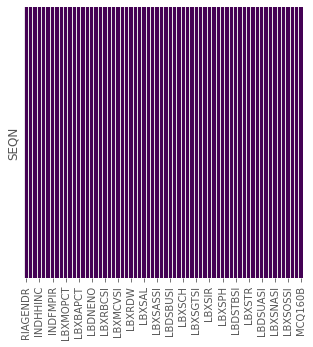

In [ ]:
# Смотрим целостность датафрейма dataset на NaN

fig, ax = plt.subplots(figsize = (5,5))
sns_heatmap = sns.heatmap(dataset.isna(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

Dataset готов к разделению на train & test

In [ ]:
#сохраняем датвасет в csv
dataset.to_csv("gero_01.csv", sep=',', index = False) # сохраняем csv

In [ ]:
#скачиваем датасет csv на диск
files.download('gero_01.csv')

# ML

## подготовка

In [ ]:
# Выводим список файлов в папке
file_list = drive.ListFile({'q': "'1etlhpufrawkeC1iVY-XXP9g-ZNvlql_O' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [ ]:
#Подгружаем данные
#1
train_downloaded = drive.CreateFile({'id': '1sLXbQV8siqnIBRQ0fEOFMyygjXN1PcCN'})
train_downloaded.GetContentFile('gero_01 (1).csv')

In [ ]:
dataset = pd.read_csv('gero_01.csv')
dataset = dataset.fillna(dataset.mean())
dataset.head(3)

,RIAGENDR,RIDAGEMN,INDFMINC,INDHHINC,DMDMARTL,RIDRETH1,INDFMPIR,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,LBDEONO,LBDBANO,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXSAL,LBDSALSI,LBXSATSI,LBXSASSI,LBXSAPSI,LBXSBU,LBDSBUSI,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSC3SI,LBXSGTSI,LBXSGL,LBDSGLSI,LBXSIR,LBDSIRSI,LBXSLDSI,LBXSPH,LBDSPHSI,LBXSTB,LBDSTBSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI,LBXSCR,LBDSCRSI,LBXSNASI,LBXSKSI,LBXSCLSI,LBXSOSSI,LBXSGB,LBDSGBSI,MCQ160B
0,2.0,-1.651695,-1.593689,-1.994973,0.221957,0.916553,-0.928971,7.299697,33.567771,8.023507,54.717072,3.042039,0.696453,2.399367,0.568671,4.0662,0.217859,4.190353e-02,4.66983,13.814889,40.713872,87.377812,29.65389,34.000383,12.970128,271.852178,8.047882,4.292989,42.929894,24.098949,25.269253,87.414727,12.805391,4.572136,9.474991,2.368748,187.981089,4.861209,24.582208,26.440795,98.106992,5.445862,84.780471,15.184513,133.626978,3.862182,1.250153,0.685092,11.818497,7.24525,72.452495,137.980962,1.557811,5.315611,316.17253,0.849547,75.144094,139.115918,3.999445,103.580609,277.713014,2.952956,29.529565,0.0
1,1.0,1.952942,2.062087,0.292809,0.221957,0.097000,1.528525,7.600000,21.100000,7.100000,66.800000,4.400000,0.500000,1.600000,0.500000,5.1000,0.300000,5.397605e-79,4.73000,14.100000,41.800000,88.500000,29.70000,33.600000,13.700000,214.000000,7.700000,4.500000,45.000000,16.000000,19.000000,62.000000,19.000000,6.800000,9.300000,2.325000,203.000000,5.250000,28.000000,20.000000,78.000000,4.330000,63.000000,11.280000,140.000000,3.300000,1.066000,0.700000,12.000000,7.20000,72.000000,115.000000,1.298000,6.100000,362.80000,0.700000,61.900000,144.100000,4.060000,104.500000,288.000000,2.700000,27.000000,2.0
2,2.0,-0.865647,-0.873707,-0.419760,0.221957,0.097000,-0.364566,7.500000,37.800000,8.100000,39.000000,14.900000,0.300000,2.800000,0.600000,2.9000,1.100000,5.397605e-79,4.52000,13.700000,39.300000,86.900000,30.30000,34.800000,11.700000,270.000000,8.600000,4.292989,42.929894,24.098949,25.269253,87.414727,12.805391,4.572136,9.474991,2.368748,187.981089,4.861209,24.582208,26.440795,98.106992,5.445862,84.780471,15.184513,133.626978,3.862182,1.250153,0.685092,11.818497,7.24525,72.452495,137.980962,1.557811,5.315611,316.17253,0.849547,75.144094,139.115918,3.999445,103.580609,277.713014,2.952956,29.529565,0.0


In [ ]:
# Разделяем выборку
y = dataset['MCQ160B']
X = dataset.drop(['MCQ160B'], axis=1)

In [ ]:
X[2]

KeyError: ignored

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X[2]

array([ 9.83707561e-01, -1.04922143e+00, -1.04065931e+00, -4.27721760e-01,
        2.27397625e-01,  8.67725457e-02, -3.79559768e-01,  9.08065442e-02,
        4.26838117e-01,  3.48574774e-02, -1.44308910e+00,  5.23488813e+00,
       -7.77404914e-01,  3.42885701e-01,  1.62649894e-01, -7.02903233e-01,
        4.85946410e+00, -6.89576573e-01, -3.37159212e-01, -8.23853238e-02,
       -3.51693630e-01, -8.26758627e-02,  2.87864631e-01,  9.63617658e-01,
       -1.10573125e+00, -2.67089826e-02,  6.38644561e-01,  7.98651908e-13,
        3.52837261e-13, -1.08822998e-14, -1.07303281e-13,  6.43115057e-14,
       -1.29271730e-13, -1.16428576e-13, -3.84200135e-13, -3.78465805e-13,
       -2.35915457e-13, -1.33233564e-13,  1.01637194e-12,  4.81331384e-14,
        1.61237000e-13, -7.17777372e-13, -2.10514450e-13, -4.51564038e-14,
       -4.54895433e-13, -2.75055042e-13, -9.00855514e-13, -1.07576777e-14,
        2.46734557e-13, -4.53856142e-13,  4.08911165e-13,  5.70504560e-14,
       -5.56991868e-14,  

In [ ]:
# validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Печать выборочного X
X[60452:]

array([[-1.01656228e+00,  9.14941189e-02,  5.59859125e-02, ...,
        -1.35630306e-13, -2.10508541e-13,  1.77117531e-13],
       [ 9.83707561e-01,  9.14941189e-02,  5.59859125e-02, ...,
         5.45682616e-01, -4.16694872e-01, -4.16694872e-01],
       [-1.01656228e+00,  9.14941189e-02,  5.59859125e-02, ...,
         3.39075765e-13,  3.58106483e-13, -4.39406333e-13],
       ...,
       [-1.01656228e+00,  9.14941189e-02,  5.59859125e-02, ...,
         1.26149269e+00, -6.89121937e-01, -6.89121937e-01],
       [-1.01656228e+00,  9.14941189e-02,  5.59859125e-02, ...,
         3.39075765e-13,  3.58106483e-13, -4.39406333e-13],
       [ 9.83707561e-01,  9.14941189e-02,  5.59859125e-02, ...,
        -6.47334172e-01, -1.44267808e-01, -1.44267808e-01]])

## Объявление функций классификаторов

Объявление функций осуществляется с использорванием перебора параметров классификатора GridSearchCV

Основным классифкатором выбран kNN


Дополнительно использованы классифкаторы SVM (poly and linear), а также bayes (Guassian)

Metrics

In [ ]:
# Metrics
def value_of_metrics(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    print('Confusion Matrix: ')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('My DataSet')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**kNN**

In [ ]:
# kNN 
def get_knn(X_train, y_train, metrics, n_neighbors, scoring = 'accuracy', cv = 5):
  
  classifier = KNeighborsClassifier()
  parametrs = {'n_neighbors': n_neighbors, 'metric': metrics}
  grider = GridSearchCV(estimator = classifier, param_grid=parametrs,
                      cv=cv,n_jobs=-1)
  grider.fit(X_train, y_train)
  
  return grider

In [ ]:
# Результат KNN
KNN = get_knn(X_train, y_train, ['manhattan', 'chebyshev', 'minkowski'], range(2,100,2))
print('kNN accuracy = ',KNN.best_score_, '. kNN лучший результат с парметрами = ', KNN.best_params_)

SVM

In [ ]:
# SVM POLYNOMIAL 
def get_svm_poly(X_train, y_train, C, degree, scoring = 'accuracy', cv =5):
  classifier = svm.SVC(kernel = 'poly', gamma = 'auto')
  parametrs = {'degree': degree, 'C': C}
  grider = GridSearchCV(estimator = classifier, param_grid = parametrs,
                     scoring = scoring, cv=cv, n_jobs= -1)
  grider.fit(X_train, y_train)
  
  return grider

In [ ]:
# SVM LINEAR
def get_svm_line(X_train, y_train, C, scoring = 'accuracy', cv =5):
  classifier = svm.SVC(kernel= 'linear')
  parametrs = {'C' : C}
  grider = GridSearchCV(estimator = classifier, param_grid = parametrs,
                       scoring = scoring, cv = cv, n_jobs =-1)
  grider.fit(X_train, y_train)
  
  return grider

bayes

In [ ]:
def get_bayes(X_train, y_rain, var_smoothing = np.linspace(1e-13, 1e-7, num=25), cv = 5, scoring = 'accuracy'):
  classifier = GaussianNB()
  parametrs = {'var_smoothing': var_smoothing}
  grider = GridSearchCV(estimator=classifier, param_grid = parametrs, 
                        scoring = scoring, cv = cv, n_jobs=-1)
  grider.fit(X_train, y_train)
  
  return grider

Random forest

In [ ]:
# функция для random forest
def get_random_forest(X, y, scoring='recall', cv=5):
  parametrs = {"n_estimators": [8, 15, 25,50],"criterion": ["gini","entropy"],
               "max_depth": [2, 3, 4, 5, None],"min_samples_split": [2, 3, 4, 5],"min_samples_split": [2, 3, 4, 5]}
  classifier = RandomForestClassifier()
  
  grider = GridSearchCV(estimator=classifier,
                        param_grid=parametrs,
                        scoring=scoring,cv=cv,n_jobs=-1)
  
  grider.fit(X, y)
  
  return grider

## Запуск функций классификаторов

**kNN**

In [ ]:
# Результат KNN
KNN = get_knn(X_train, y_train, ['manhattan', 'chebyshev', 'minkowski'], range(2,100,2))
print('kNN accuracy = ',KNN.best_score_, '. kNN лучший результат с парметрами = ', KNN.best_params_)

In [ ]:
# сохраним лучшие парметры
joblib.dump(KNN.best_estimator_, 'best_KNN.pkl')

In [ ]:
#скачиваем best knn  на диск
files.download('best_KNN.pkl')

SVM

svm poly

In [ ]:
# SVM poly
%%time
C = [1,3,7,9,14]
degree = [2,4,6,9,12]
SVM_poly = get_svm_poly(X_train, y_train, C, degree)
print('SVM poly accuracy = ', SVM_poly.best_score_, 'SVM poly best parametrs = ', SVM_poly.best_params_)

In [ ]:
# сохраним лучшие парметры best svm poly
joblib.dump(SVM_poly.best_estimator_, 'best_svm_poly.pkl')

In [ ]:
#скачиваем best svm poly  на диск
files.download('best_svm_poly.pkl')

svm linear

In [ ]:
# SVM linear
SVM_line = get_svm_line(X_train, y_train, C)
print('SVM linear accuracy = ', SVM_line.best_score_,'SVM linear best parametrs = ', SVM_line.best_params_)

In [ ]:
# сохраним лучшие парметры best svm linear
joblib.dump(SVM_line.best_estimator_, 'best_svm_line.pkl')

In [ ]:
#скачиваем best svm linear  на диск
files.download('best_svm_line.pkl')

**bayes**

In [ ]:
# Обучаем bayes 
%%time

bayes = get_bayes(X_train, y_train)
print('Bayes accuracy = ', bayes.best_score_, 'Bayes best parametrs = ', bayes.best_params_)

In [ ]:
# сохраним лучшие парметры best bayes
joblib.dump(bayes.best_estimator_, 'best_bayes.pkl')

In [ ]:
#скачиваем best bayes  на диск
files.download('best_bayes.pkl')

**Random forest**

In [ ]:
# RandomForestClassifier
RF = get_random_forest(X,y)

In [ ]:
print('RandomForestClassifier accuracy = ', RF.best_score_,'RandomForestClassifier best parametrs = ', RF.best_params_)

## Predict

 **Пробуем предсказать класс  наличия
сердечно-сосудистых заболеваний по демографическому опроснику и анализам крови.**

2.0 - отрицательный

1.0 - положительный

9.0 - зона риска, требуется повторный анализ

7.0 - зона риска, требуется повторный анализ 

0.0 - зона риска, требуется повторный анализ

In [ ]:
files.upload()

In [ ]:
!ls

In [ ]:
# Смотрим размер X_test
X_test.shape

Определим последние 10 классов, на тестовой выборке



#### **Predict KNN**

In [ ]:
kNN_pred = KNN.predict(X_test[18560:])
kNN_pred 

####**Predict SVM**

In [ ]:
# SVM poly
SVM_poly_pred = SVM_poly.predict(X_test[18560:])
SVM_poly_pred

In [ ]:
# SVM linear
SVM_line_pred = SVM_line.predict(X_test[18560:])
SVM_line_pred

**Predict bayes**

In [ ]:
bayes_pred = bayes.predict(X_test[18560:])
bayes_pred

**Predict random forest**

In [ ]:
#Predict
RF_predict = RF.predict(X_test)
RF_predict

### Метрики моделей

In [ ]:
# kNN confusion matrix
value_of_metrics(y_test, kNN_pred)

In [ ]:
# SVM polynomial confusion matrix
value_of_metrics(y_test, SVM_poly_pred)

In [ ]:
# SVM linear confusion matrix
value_of_metrics(y_test, SVM_line_pred)

In [ ]:
# Bayes confusion matrix
value_of_metrics(y_test, bayes_pred)

In [ ]:
# RF confusion matrix
value_of_metrics(y_test, RF_predict)

### Cохраняем и загружаем predict из pkl

**Используем лучшие параметры из GridSearch**

**kNN**

In [ ]:
# классификатор
kNN = KNeighborsClassifier(n_neighbors=80, metric='manhattan')

In [ ]:
# обучаем
kNN.fit(X_train, y_train)

In [ ]:
# предикт
kNN_predict = kNN.predict(X_test[18560:])

In [ ]:
print(kNN_predict)

**Сохраняем классификатор**

In [ ]:
# сохраняем классификатор
pickle.dump(kNN, open('KNN.pkl', 'wb'))

In [ ]:
files.download('KNN.pkl')

In [ ]:
!ls

**Загрузка классификатора**

In [ ]:
# загружаем классификатор
model = pickle.load(open('KNN.pkl', 'rb'))

In [ ]:
print(model.predict(X_test[18560:]))

# Neural networks

Обучение нейронных сетей:
1. Подбор архитектуры

2. Работа с переобучением

3. Повышение точности

4. Выводы

5. Сравнение с классическими ML алгоритмами

## Подбор архитектуры

## Повышение точности

## Выводы